# Pythonic Implentation of the PINN(Physics Informed Neural Network)

In [1]:
# importing the libraries
import numpy as np
import torch
import torch.nn as nn
import  matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Generate Data

# Some parameters
u0 = 10.0
g = 9.81
h0 = 1.0


# Genrate some time points
t_min = 0.0;  t_max = 2.0
N_data = 10
t_data = np.linspace(t_min, t_max, N_data)

# Generate newtonian model data
def _newtonian(t):
    return h0+ u0*t -0.5*g*t**2

# Newtonian model data
h_newtonian = _newtonian(t_data)

# Experimental data
np.random.seed(0)
noise_level = 0.7
h_expt = h_newtonian + noise_level*np.random.randn(N_data)

# conversion to torch tensors
h_newtonian_tensor = torch.tensor(h_newtonian, dtype = torch.float32).reshape(-1,1)
h_expt_tensor = torch.tensor(h_expt, dtype= torch.float32).reshape(-1,1)
t_data_tensor = torch.tensor(t_data, dtype = torch.float32, requires_grad= True).reshape(-1,1)



Text(0, 0.5, 'Height (m)')

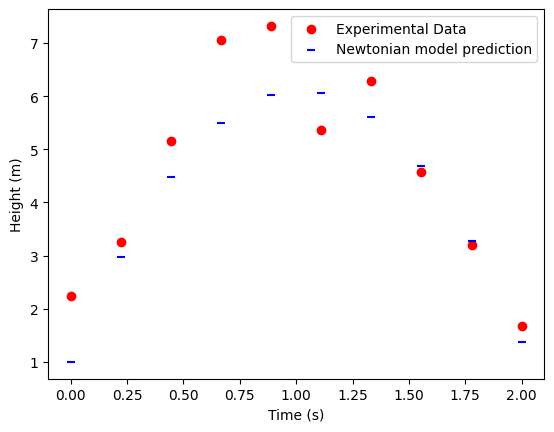

In [3]:
# lets visualise the data points

plt.scatter(t_data, h_expt, label='Experimental Data', marker= 'o', color='red')
plt.scatter(t_data, h_newtonian, label='Newtonian model prediction', marker= '_', color='blue')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Height (m)')


In [4]:
# Helper func for Automatic Differentiation

def derivative(y, x):
    """
    Computes the derivative of y with respect to x.
    where y and x are both tensors such that x.requires_grad is True
    """

    return torch.autograd.grad(y, x, torch.ones_like(y), create_graph=True)[0]

# By using torch.ones_like(y), we're effectively computing the Jacobian-vector product where the vector is all ones.
# When y is a scalar, this is just 1, making it a standard derivative.
# When y is a vector, this computes the sum of gradients for each element of y.


# create_graph = True, This enables the computation of higher-order derivatives.
# When set to True, the computed gradients will have computational history retained.
# This is crucial for PINNs where you often need second derivatives (like in differential equations).

In [9]:
# Defining loss funcctions

def physics_loss(model, t_data_tensor):
    # Grad of h of the nn model wrt t
    h_pred_tensor = model(t_data_tensor)
    dh_pred_dt_tensor = derivative(h_pred_tensor, t_data_tensor)

    # Grad of h newtonian model 
    dh_newtonian_dt_tensor = u0 - g*t_data_tensor

    # Loss
    loss = torch.mean((dh_pred_dt_tensor - dh_newtonian_dt_tensor)**2)

    return loss


def initial_loss(model):

    t0 = torch.zeros(1, 1, dtype = torch.float32, requires_grad= False)

    # Predicted IC
    h_pred_0 = model(t0)

    # Loss
    loss = (h_pred_0 - h0)**2

    return loss

def data_loss(model, t_data_tensor):

    h_pred_tensor = model(t_data_tensor)

    # loss
    loss = torch.mean((h_pred_tensor- h_expt_tensor)**2)
    
    return loss


In [38]:
# defining a small feed-forward nn 

class PINN(nn.Module):
    def __init__(self, n_hidden = 20):
        super().__init__()

        # A simple MLP with 2 hidden layers
        self.net = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, 1)
        )

    
    def forward(self, t):
        # The forward function performs the forward passqq

        return self.net(t)

# Instantiate the model
model = PINN(n_hidden=20)

In [39]:
# Training setup

optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

#hyperparameters for the loss terms
lambda_ODEloss = 5.0
lambda_ICLoss = 1.0
lambda_DataLoss = 1.0

n_epochs = 2000
n_print_every = 100

In [40]:
# Training loop 

model.train()
for i in range(n_epochs):
    optimizer.zero_grad()

    out = model(t_data_tensor)

    # Compute the loss
    l_data= data_loss(model, t_data_tensor)
    l_IC = initial_loss(model)
    l_ODE = physics_loss(model, t_data_tensor)
    loss = lambda_DataLoss* l_data + lambda_ICLoss* l_IC + lambda_ODEloss* l_ODE

    loss.backward()

    optimizer.step()

    if (i+1)%n_print_every ==0:
        print(f"Epoch {i+1}/{n_epochs}, "
            f"Net Loss: {loss.item():.4f}, "
            f"Data Loss: {l_data.item():.4f}, "
            f"Initial Condition Loss: {l_IC.item():.4f}, "
            f"Physics Loss: {l_ODE.item():.4f}"
        )
   


Epoch 100/2000, Net Loss: 33.6929, Data Loss: 1.8769, Initial Condition Loss: 0.0528, Physics Loss: 6.3527
Epoch 200/2000, Net Loss: 0.5722, Data Loss: 0.5138, Initial Condition Loss: 0.0506, Physics Loss: 0.0016
Epoch 300/2000, Net Loss: 0.5679, Data Loss: 0.5151, Initial Condition Loss: 0.0468, Physics Loss: 0.0012
Epoch 400/2000, Net Loss: 0.5659, Data Loss: 0.5144, Initial Condition Loss: 0.0458, Physics Loss: 0.0011
Epoch 500/2000, Net Loss: 0.5640, Data Loss: 0.5137, Initial Condition Loss: 0.0447, Physics Loss: 0.0011
Epoch 600/2000, Net Loss: 0.5622, Data Loss: 0.5131, Initial Condition Loss: 0.0436, Physics Loss: 0.0011
Epoch 700/2000, Net Loss: 0.5602, Data Loss: 0.5124, Initial Condition Loss: 0.0423, Physics Loss: 0.0011
Epoch 800/2000, Net Loss: 0.5580, Data Loss: 0.5117, Initial Condition Loss: 0.0409, Physics Loss: 0.0011
Epoch 900/2000, Net Loss: 0.5555, Data Loss: 0.5109, Initial Condition Loss: 0.0394, Physics Loss: 0.0011
Epoch 1000/2000, Net Loss: 0.5528, Data Loss:

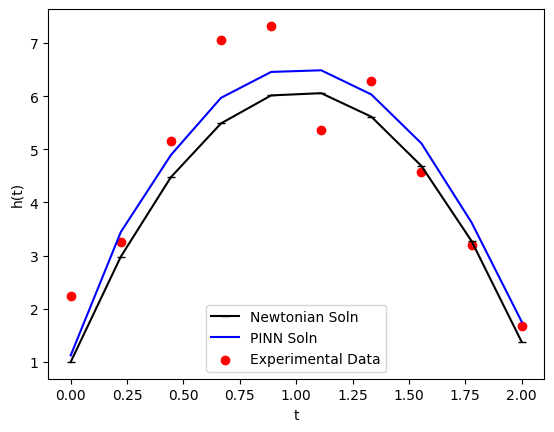

In [41]:
# Evaluating the model
model.eval()
h_pred = model(t_data_tensor).detach().numpy()
t_data = t_data_tensor.detach().numpy()

plt.plot(t_data, h_newtonian, label= 'Newtonian Soln', marker= '_', color = 'black' )
plt.plot(t_data, h_pred, label= 'PINN Soln', color = 'blue')
plt.scatter(t_data, h_expt, label= 'Experimental Data', color = 'red')
plt.xlabel('t')
plt.ylabel('h(t)')
plt.legend()
